# Good photo / bad photo - my first Neural Network!

## Setup

- Import TensorFlow and other necessary libraries.
- Keras in TensorFlow is a high-level API designed for constructing and training deep learning models in a user-friendly and modular manner.








In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Hookup the dataset

In this example, I'm going to add some photos to my Google Drive,
and point Tensorflow to the right place.

In [10]:
import pathlib
import tensorflow as tf

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
data_dir = '/content/drive/My Drive/tensorflow'

# Convert to pathlib.Path object
data_dir = pathlib.Path(data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We can check that our dataset has been loaded accurately by printing the count, and checking a photo from each class.


In [11]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)
# good_photos = list(data_dir.glob('good/*'))
# PIL.Image.open(str(good_photos[0]))
# bad_photos = list(data_dir.glob('bad/*'))
# PIL.Image.open(str(bad_photos[0]))

### Create a dataset

First we'll define some parameters for the loader. Then, we'll use 80% of the data to train the model and 20% to validate the model and evaluate its accuracy.

In [14]:
batch_size = 9
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Check for dataset errors
import os
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        filepath = os.path.join(subdir, file)
        try:
            img = tf.io.read_file(filepath)
            img = tf.io.decode_image(img)
        except Exception as e:
            print(f"Error with file: {filepath}")
            print(e)

class_names = train_ds.class_names
print("the class names found are:", class_names)

Found 28 files belonging to 2 classes.
Using 23 files for training.
Found 28 files belonging to 2 classes.
Using 5 files for validation.
the class names found are: ['bad', 'good']


## Visualize the data

Here are the first nine images from the training dataset:

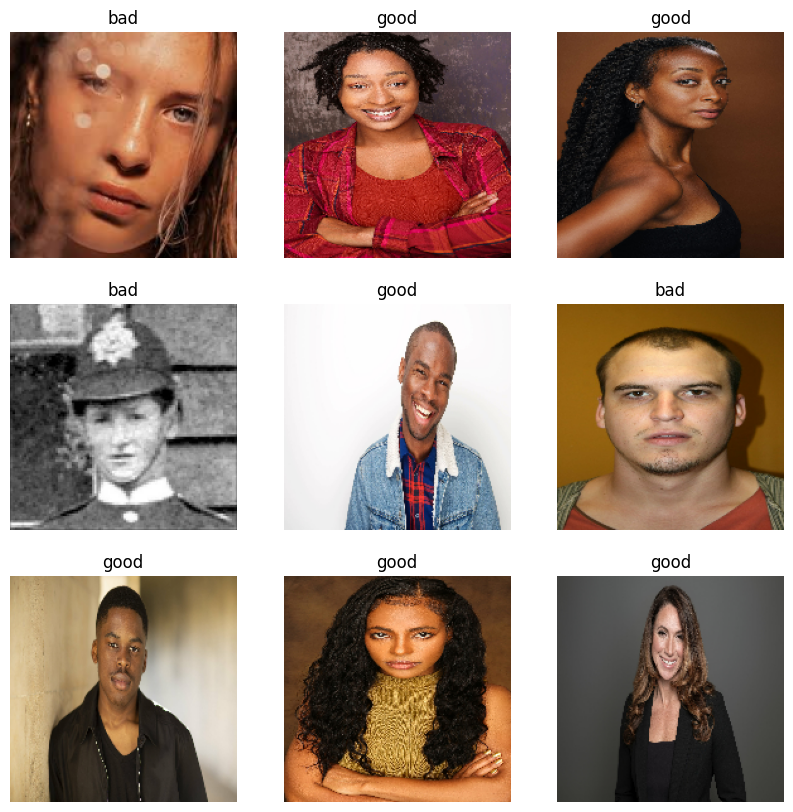

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data. `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`: and apply it to the dataset by calling `Dataset.map`:

In [17]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top
 of it that is activated by a ReLU activation function (`'relu'`).:

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

*   **Adam** is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data. It's often preferred due to its effective handling of large datasets and high-dimensional spaces.
*   **SparseCategoricalCrossentropy**: This loss function is used for multi-class classification problems where the labels are integers (like in image classification tasks where each class is assigned a unique integer).
*   **Metrics**: allows us to view training and validation accuracy for each training epoch.

`model.summary()` can be used to view the details, if needed.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method. An epoch is a single pass through the entire training dataset during the training process of a model.

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 5s 306ms/step - loss: 3.8530 - accuracy: 0.5217 - val_loss: 0.8781 - val_accuracy: 0.4000
Epoch 2/10
3/3 [==============================] - 0s 23ms/step - loss: 0.8033 - accuracy: 0.4783 - val_loss: 0.7679 - val_accuracy: 0.4000
Epoch 3/10
3/3 [==============================] - 0s 12ms/step - loss: 0.7123 - accuracy: 0.4783 - val_loss: 0.7036 - val_accuracy: 0.4000
Epoch 4/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6798 - accuracy: 0.4783 - val_loss: 0.6824 - val_accuracy: 0.6000
Epoch 5/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6419 - accuracy: 0.8696 - val_loss: 0.6877 - val_accuracy: 0.6000
Epoch 6/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6037 - accuracy: 0.8696 - val_loss: 0.6877 - val_accuracy: 0.2000
Epoch 7/10
3/3 [==============================] - 0s 12ms/step - loss: 0.5910 - accuracy: 0.8696 - val_loss: 0.6862 - val_accuracy: 0.4000
Epoch 8/10
3/3 [==========

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets. You want to see accuracy going up over time, and the loss going down.

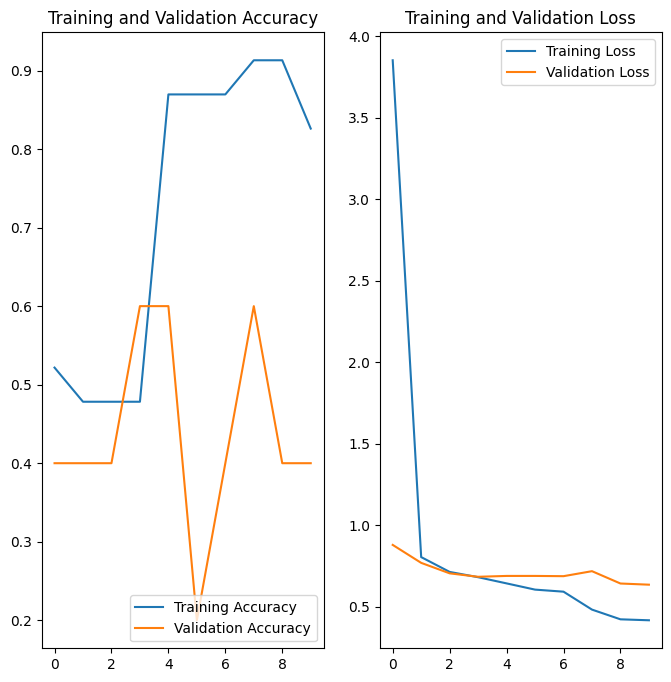

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fighting overfitting - Data augmentation

* Overfitting often happens with few training examples; data augmentation generates more data from existing ones through random transformations, creating realistic images to improve model generalization.

* Implement data augmentation in Keras using `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`, which can be included as layers in your model and processed on the GPU.

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# If you want to view some of the augmented examples after generation

'''
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
'''

'\nplt.figure(figsize=(10, 10))\nfor images, _ in train_ds.take(1):\n  for i in range(9):\n    augmented_images = data_augmentation(images)\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(augmented_images[0].numpy().astype("uint8"))\n    plt.axis("off")\n'

## Fighting overfitting - Dropout

* Introduce dropout to your neural network using tf.keras.layers.Dropout to reduce overfitting.

* Dropout randomly sets a portion of input units to zero during training, with a specified rate like 0.1 (10%), 0.2 (20%), etc.

* Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Re-compile the model



Epoch 1/15
3/3 [==============================] - 3s 86ms/step - loss: 2.1235 - accuracy: 0.3043 - val_loss: 0.8386 - val_accuracy: 0.4000
Epoch 2/15
3/3 [==============================] - 0s 18ms/step - loss: 0.7984 - accuracy: 0.4783 - val_loss: 0.7676 - val_accuracy: 0.4000
Epoch 3/15
3/3 [==============================] - 0s 19ms/step - loss: 0.7060 - accuracy: 0.4783 - val_loss: 0.7258 - val_accuracy: 0.4000
Epoch 4/15
3/3 [==============================] - 0s 19ms/step - loss: 0.7041 - accuracy: 0.4783 - val_loss: 0.7009 - val_accuracy: 0.4000
Epoch 5/15
3/3 [==============================] - 0s 28ms/step - loss: 0.6937 - accuracy: 0.3913 - val_loss: 0.6925 - val_accuracy: 0.6000
Epoch 6/15
3/3 [==============================] - 0s 18ms/step - loss: 0.6931 - accuracy: 0.5217 - val_loss: 0.6908 - val_accuracy: 0.6000
Epoch 7/15
3/3 [==============================] - 0s 17ms/step - loss: 0.6910 - accuracy: 0.6087 - val_loss: 0.6944 - val_accuracy: 0.6000
Epoch 8/15
3/3 [===========

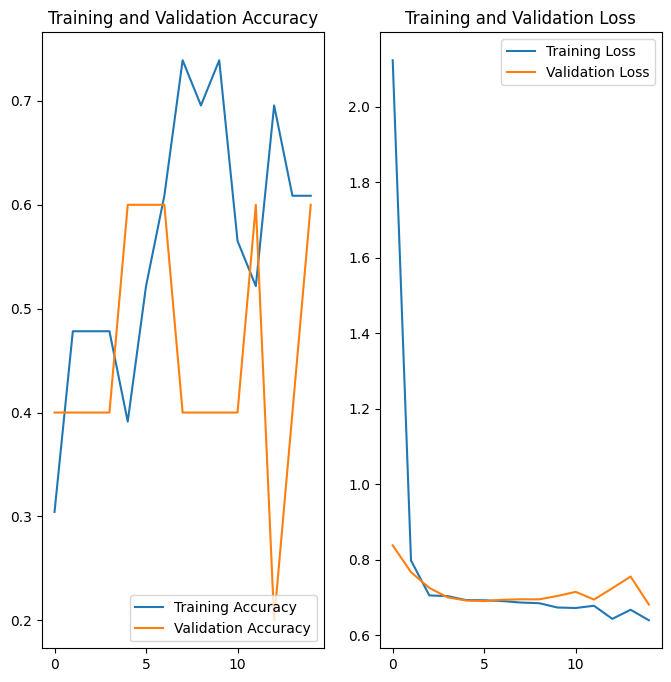

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

# Fit

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Plot again for accuracy/validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use to your model to predict based on new input data 🚀

1/1 [==============================] - 0s 367ms/step


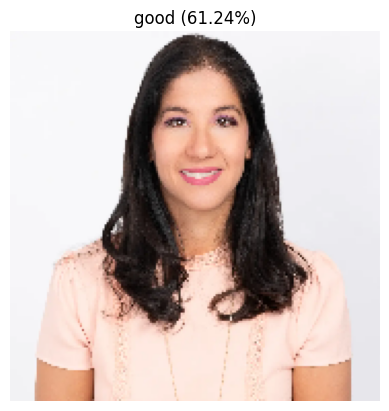

1/1 [==============================] - 0s 24ms/step


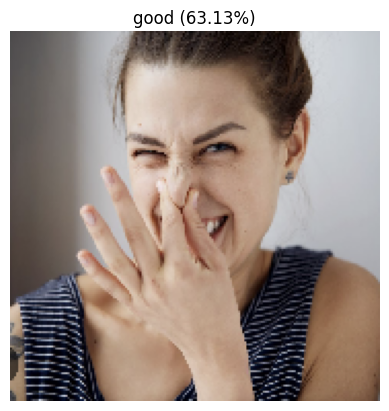

1/1 [==============================] - 0s 17ms/step


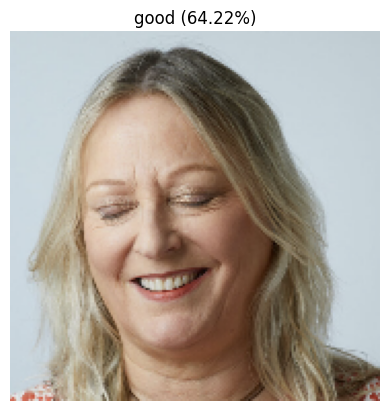

1/1 [==============================] - 0s 17ms/step


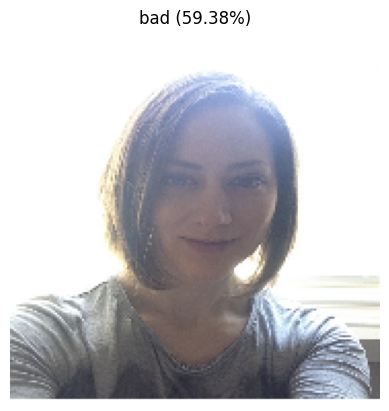

1/1 [==============================] - 0s 17ms/step


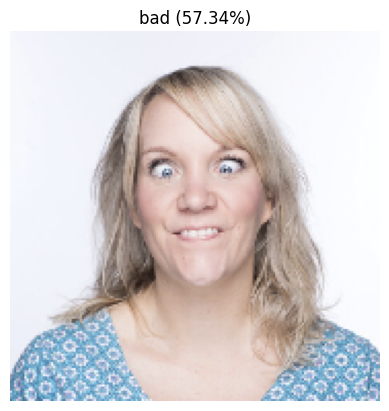

In [25]:
# Define the directory path to the folder containing the test images
directory_path = '/content/drive/My Drive/tensorflow-test/'

# Convert to pathlib.Path object to facilitate easy file manipulation
directory_path = pathlib.Path(directory_path)

# Assuming img_height and img_width are defined elsewhere in your code
# Loop through the images in the directory
for image_path in directory_path.glob('*.jpg'):  # Assuming the images are in jpg format
    # Load the image, ensuring the image is resized to the target size
    img = tf.keras.utils.load_img(
        image_path, target_size=(img_height, img_width)
    )

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis

    # Convert the image to an array and create a batch
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # Make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # Get the predicted label and its confidence score
    predicted_label = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    # Show the plot with the predicted label
    plt.title(f"{predicted_label} ({confidence:.2f}%)")
    plt.show()